# Autoencoders

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 06 – Computer Vision Applications/2- Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->




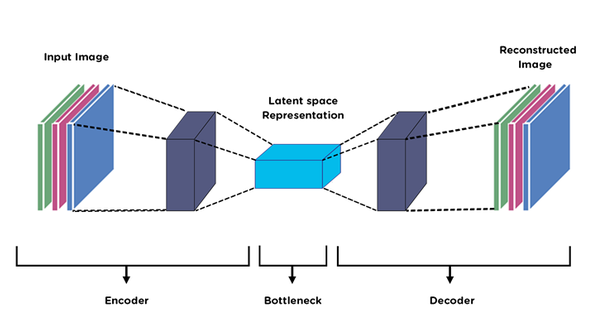

**Autoencoders** : are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). 

These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. 

Lastly, some autoencoders are generative models: they
are capable of randomly generating new data that looks very similar to the training data. 

For example, you could train an autoencoder on pictures of faces, and it would
then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.
## How Autoencoders are Working 
**Autoencoder**  In the case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image. Encoder-Decoder automatically consists of the following two structures:

* **The encoder**- This network downsamples the data into lower dimensions.
* **The decoder**- This network reconstructs the original data from the lower dimension representation.
The lower dimension (i.e, output of encoder network) representation is usually known as latent space representation.


Before we get into the technical details of Autoencoder, let us look at some interesting applications it is used in:


*   Remove noise from an image (denoising).

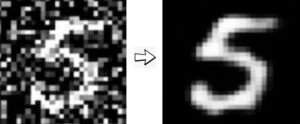

Clearing noise and clarifying the details in an image

*   Fill in the missing pieces in an image (Image Inpainting).

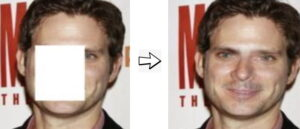

Demo of filling in missing pieces of an image

* Dimensionality reduction, clustering, and in recommender systems.

* A class of Autoencoder known as Variational Autoencoder can even learn to generate data.

* Autoencoders are used as a Feature Extractor for downstream tasks such as  classification, and detection.

* Autoencoders are also widely leveraged in Semantic Segmentation. 

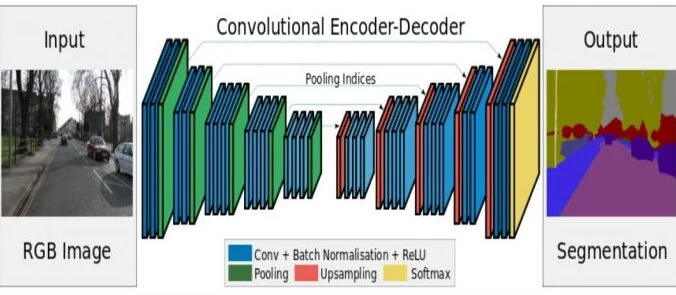


#Denoising Autoencoders



#Image denoising
**Image Denoising** is the process of removing noise from the Images
The noise present in the images may be caused by various intrinsic or extrinsic conditions which are practically hard to deal with.

 The problem of Image Denoising is a very fundamental challenge in the domain of Image processing and Computer vision. Therefore, it plays an important role in a wide variety of domains where getting the original image is really important for robust performance.


In other words we force the autoencoder to learn useful features be  adding a noise to its inputs, training it to recover the original, noise-free inputs.

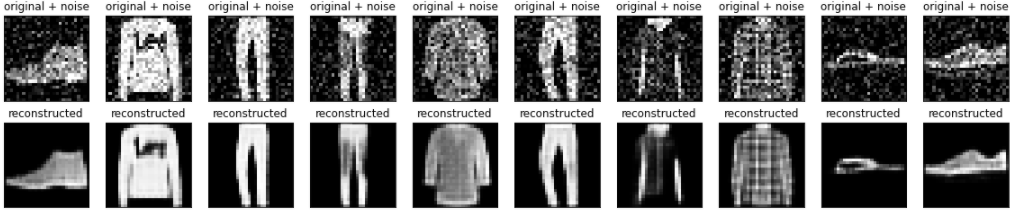




An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

#Import the python libraries

In [ ]:
# import python libraries for the project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score

#Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels

In [ ]:
# download fashion mnist without the labels
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# scale the pixel values between 0-1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# add extra dimensions to the gray images
# the extra dimension represent the channel dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# check the images shape
print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Create the data pipline with adding random noise to the images


While solving the problem statement, we have to remember our goal which is to make a model that is capable of performing noise removal on images. To be able to do this, we will use existing images and add them to random noise. Here we will feed the original images as input and we get the noisy images as output and our model (i.e, autoencoder) will learn the relationship between a clean image and a noisy image and learn how to clean a noisy image. So let’s create a noisy version of our fashion mnist dataset and give it as input to the decoder network.

In [ ]:
def add_noise_to_images(noise_images, images):
    """
    We start with defining a noise factor which is a hyperparameter.
    The noise factor is multiplied with a random matrix that has a mean of 0.0 and a standard deviation of 1.0.
    This matrix will draw samples from a normal (Gaussian) distribution.
    While adding the noise, we have to remember that the shape of the random normal array will be similar to the shape of the data you will be adding the noise.
    """
    noise_factor = (
        0.2  # noise factor that will control the noise that will be added to the image
    )
    x = noise_images + noise_factor * tf.random.normal(
        shape=noise_images.shape
    )  # adding the noise
    x = tf.clip_by_value(
        x, clip_value_min=0.0, clip_value_max=1.0
    )  # clip by the value to make sure that the pixels value are between 0 and 1
    return x, images

In [ ]:
# create the the data pipline
def Dataset_creater(noise_images, images):
    data = tf.data.Dataset.from_tensor_slices((images, noise_images))
    data = data.shuffle(1080)  # shuffle the images
    data = data.map(
        add_noise_to_images, num_parallel_calls=tf.data.AUTOTUNE
    )  # add noise to images
    data = data.batch(32)  # create batches
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

In [ ]:
train_dataset = Dataset_creater(x_train, x_train)  # create the training data pipline
test_dataset = Dataset_creater(x_test, x_test)  # create the testing data pipline

Plot the noisy images.


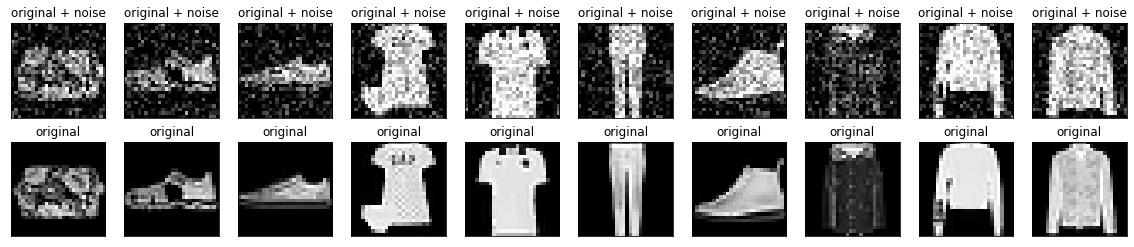

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for noise_images, images in train_dataset.take(1):

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noise_images[i]))  # plot the noisy images
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, n + i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(images[i]))  # plot  images without noise
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)


plt.show()

#Create the Autoencoders Model

##Encoder 
Here, we define the encoder network, which takes an input of size [None, 28, 28, 1]. There are five Conv blocks, each consisting of a Conv2D, BatchNorm and LeakyReLU activation function. at the second Conv and fourth Conv the image is down sampled by a factor of two.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

        # block 1
        # conv2D that have 16 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_1 = tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        # block 2
        # conv2D that have 32 filters with kernel_size=(3,3) with strides=(2,2)
        # block 2 used to down sampling image size from 28,28 to 14,14
        self.Conv_2 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()
        # block 3
        # conv2D that have 64 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_3 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_3 = tf.keras.layers.BatchNormalization()
        # block 4
        # conv2D that have 128 filters with kernel_size=(3,3) with strides=(2,2)
        # block 4 used to down sampling image size from 14,14 to 7,7
        self.Conv_4 = tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_4 = tf.keras.layers.BatchNormalization()
        # block 5
        # conv2D that have 256 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_5 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_5 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        # block 1
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)
        # block 2
        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)
        # block 3
        x = self.Conv_3(x)
        x = self.BN_3(x)
        x = tf.nn.leaky_relu(x)
        # block 4
        x = self.Conv_4(x)
        x = self.BN_4(x)
        x = tf.nn.leaky_relu(x)
        # block 5
        x = self.Conv_5(x)
        x = self.BN_5(x)
        x = tf.nn.leaky_relu(x)

        return x

    def build_model(self, dim):
        x = tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


encoder = Encoder()
encoder.build_model((28, 28, 1)).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        144       
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 tf.nn.leaky_relu_20 (TFOpLa  (None, 28, 28, 16)       0         
 mbda)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        4608      
                                                                 
 batch_normalization_21 (Bat  (None, 14, 14, 32)       128 

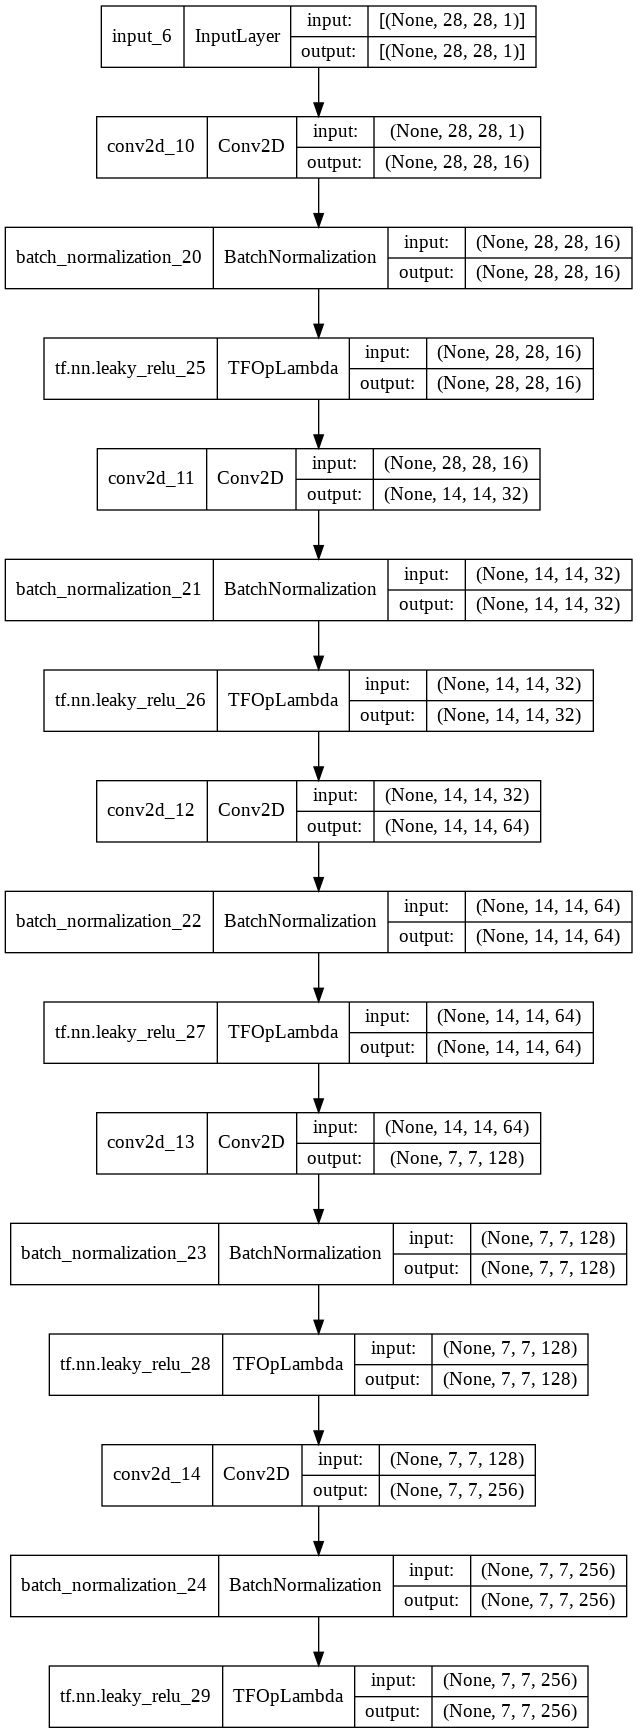

In [ ]:
tf.keras.utils.plot_model(encoder.build_model((28, 28, 1)), show_shapes=True)

##Decoder
At the Decoder we are using special Convolution layer called Conv2DTranspose .

**[Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)** is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample  its input by using nearest neighbour or bilinear upsampling, but the key difference from the Conv2D is the model should learn what is the best upsampling for the job.  


The decoder network takes an input of size [None,7,7 256].

The initial block has a Conv2DTranspose layer having 256 filters. 

Recall that this was the size of the output in the encoder function .

There are a total of six Conv blocks. The Conv block [1, 5] consists of a Conv2DTranspose, BatchNorm and LeakyReLU activation function.

The Conv block 6 has a Conv2DTranspose with sigmoid activation function, which flattens  the output to be in the range [0, 1].

 In each block, the image is up sampled by a factor of two at block 2 and 4 .

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        # block 1
        # Conv2DTranspose that have 256 filters with kernel_size=(3,3) with strides=(1,1) that matches the output of the encoder
        self.Conv_1 = tf.keras.layers.Conv2DTranspose(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        # block 2
        # Conv2DTranspose that have 128 filters with kernel_size=(3,3) with strides=(2,2)
        # we're using stride ==(2,2) to upsample the size of the input
        self.Conv_2 = tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()
        # block 3
        # Conv2DTranspose that have 64 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_3 = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_3 = tf.keras.layers.BatchNormalization()
        # block 4
        # Conv2DTranspose that have 32 filters with kernel_size=(3,3) with strides=(2,2)
        # we're using stride ==(2,2) to upsample the size of the input
        self.Conv_4 = tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_4 = tf.keras.layers.BatchNormalization()
        # block 5
        # Conv2DTranspose that have 128 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_5 = tf.keras.layers.Conv2DTranspose(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_5 = tf.keras.layers.BatchNormalization()
        # block 6
        # in this block we're using  Conv2DTranspose with  kernel size (1,1) so we can reduse the number of the channels to the same number
        # of channels in the input image
        self.Out = tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=(1, 1), strides=(1, 1)
        )

        # Note : you can notice that we are build the same architecture of encoder but from output to input

    def call(self, x):
        # block 1
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)
        # block 2

        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)
        # block 3

        x = self.Conv_3(x)
        x = self.BN_3(x)
        x = tf.nn.leaky_relu(x)
        # block 4

        x = self.Conv_4(x)
        x = self.BN_4(x)
        x = tf.nn.leaky_relu(x)
        # block 5
        x = self.Conv_5(x)
        x = self.BN_5(x)
        x = tf.nn.leaky_relu(x)
        # block 6
        # notice we're using sigmoid to make sure the output value of the last Conv2DTranspose will be between 0,1

        output = self.Out(x)
        output = tf.nn.sigmoid(output)

        return output

    def build_model(self, dim):
        x = tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


dncoder = Decoder()
dncoder.build_model((7, 7, 256)).summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 7, 256)]       0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 256)        589824    
 Transpose)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 7, 7, 256)        1024      
 chNormalization)                                                
                                                                 
 tf.nn.leaky_relu_30 (TFOpLa  (None, 7, 7, 256)        0         
 mbda)                                                           
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 14, 14, 128)      294912    
 Transpose)                                                

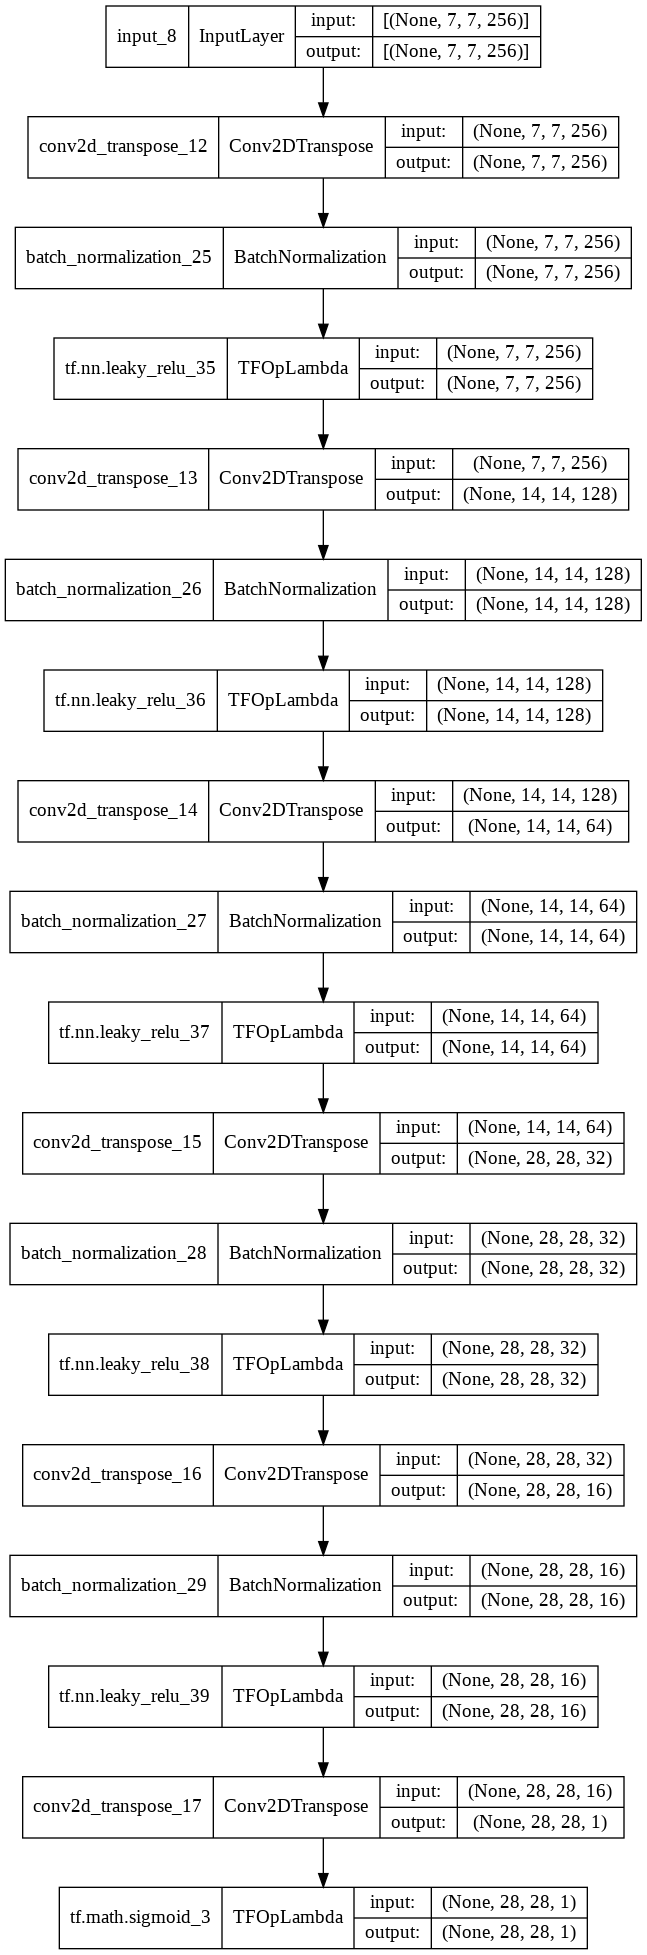

In [ ]:
tf.keras.utils.plot_model(dncoder.build_model((7, 7, 256)), show_shapes=True)

##Autoencoder Model


In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # initialize the encoder
        self.encoder = Encoder()
        # initialize the decoder
        self.decoder = Decoder()

    def call(self, x):
        # input the noisy image to the encoder
        x = self.encoder(x)
        # input the ouput of the encoder to the decoder
        x = self.decoder(x)

        # return the ouput of the decoder
        # the ouput of the decoder will be denoising image

        return x


autoencoder = Autoencoder()
autoencoder.build(input_shape=(None, 28, 28, 1))

In [ ]:
autoencoder.summary()

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  393808    
                                                                 
 decoder_3 (Decoder)         multiple                  983505    
                                                                 
Total params: 1,377,313
Trainable params: 1,375,329
Non-trainable params: 1,984
_________________________________________________________________


##train the model 

In [ ]:
autoencoder.compile(optimizer="adam", loss=tf.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
1875/1875 [==============================] - 53s 27ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 4/5
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 5/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0044 - val_loss: 0.0046


##plot the prediction of the model 

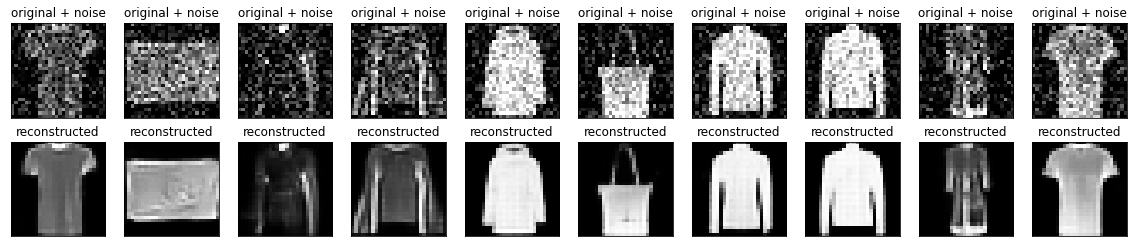

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for noisy_images, images in test_dataset.take(1):
    pred = autoencoder(noisy_images, training=False)  # make prediction
    for i in range(n):

        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noisy_images[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()